In [1]:
# !pip install accelerate -U

In [2]:
import json

# File paths
input_path = "./annotations/annotations.json"
output_path = "./annotations/annotations.json"

# Recursive function to clean dictionary keys
def clean_keys(obj):
    if isinstance(obj, dict):
        return {k.rstrip(":"): clean_keys(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [clean_keys(i) for i in obj]
    else:
        return obj

# Load original data
with open(input_path, "r") as f:
    raw_data = json.load(f)

# Clean all keys
cleaned_data = clean_keys(raw_data)

# Save cleaned data
with open(output_path, "w") as f:
    json.dump(cleaned_data, f, indent=4)

print(f"✅ Cleaned annotations saved to: {output_path}")


✅ Cleaned annotations saved to: ./annotations/annotations.json


In [3]:
import json
import os

# Step 1: Load cleaned annotation file
with open("./annotations/annotations.json", "r") as f:
    auair_data = json.load(f)

# Step 2: Convert to COCO format
def convert_auair_to_coco(auair_data, output_path="./annotations/auair.coco.json"):
    images = []
    annotations = []

    # Define COCO-style categories from class names
    categories = [{"id": i, "name": name} for i, name in enumerate(auair_data["categories"])]

    ann_id = 1  # unique annotation ID
    for img_id, entry in enumerate(auair_data["annotations"], start=1):
        image_name = entry["image_name"]
        width = entry["image_width"]
        height = entry["image_height"]

        images.append({
            "id": img_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        for bbox in entry["bbox"]:
            x = bbox["left"]
            y = bbox["top"]
            w = bbox["width"]
            h = bbox["height"]
            category_id = bbox["class"]

            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],       # COCO: [x, y, width, height]
                "area": w * h,
                "iscrowd": 0
            })
            ann_id += 1

    coco_data = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    # Step 3: Save to COCO format JSON file
    with open(output_path, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"✅ COCO-format annotations saved to: {output_path}")

# Step 4: Run the conversion
convert_auair_to_coco(
    auair_data,
    output_path="./annotations/auair_coco.json"
)


✅ COCO-format annotations saved to: ./annotations/auair_coco.json


In [4]:
import os
import json

# === PATHS ===
image_folder = "./AU-AIR/images"
annotation_file = "./annotations/auair_coco.json"
filtered_annotation_path = "./annotations/auair_coco_filtered.json"

# === LOAD ANNOTATION ===
with open(annotation_file, "r") as f:
    coco = json.load(f)

# === IMAGE NAME CHECKS ===
annotated_image_names = set(img["file_name"] for img in coco["images"])
image_files = set(os.listdir(image_folder))

missing_images = annotated_image_names - image_files
unannotated_images = image_files - annotated_image_names

# === REPORT ===
print(f"✅ Total annotated images: {len(annotated_image_names)}")
print(f"📂 Total actual image files: {len(image_files)}\n")

print(f"❌ Missing image files (in annotations but not found on disk): {len(missing_images)}")
if missing_images:
    print("Examples:", sorted(list(missing_images))[:5])

print(f"📝 Unannotated image files (exist in folder but not in annotations): {len(unannotated_images)}")
if unannotated_images:
    print("Examples:", sorted(list(unannotated_images))[:5])

# === FILTER ANNOTATIONS ===
valid_images = [img for img in coco["images"] if img["file_name"] in image_files]
valid_image_ids = set(img["id"] for img in valid_images)
valid_annotations = [ann for ann in coco["annotations"] if ann["image_id"] in valid_image_ids]

filtered_coco = {
    "images": valid_images,
    "annotations": valid_annotations,
    "categories": coco["categories"]
}

# === SAVE CLEANED JSON ===
with open(filtered_annotation_path, "w") as f:
    json.dump(filtered_coco, f, indent=4)

print(f"\n✅ Filtered COCO annotations saved to: {filtered_annotation_path}")
print(f"➡️ Valid images remaining: {len(valid_images)}")
print(f"➡️ Valid annotations remaining: {len(valid_annotations)}")


✅ Total annotated images: 32823
📂 Total actual image files: 32823

❌ Missing image files (in annotations but not found on disk): 0
📝 Unannotated image files (exist in folder but not in annotations): 0

✅ Filtered COCO annotations saved to: ./annotations/auair_coco_filtered.json
➡️ Valid images remaining: 32823
➡️ Valid annotations remaining: 132031


In [5]:
import json

# Input and output file paths
input_path = "./annotations/auair_coco_filtered.json"
output_path = "./annotations/auair_coco_cleaned.json"

# Load COCO annotations
with open(input_path, "r") as f:
    coco = json.load(f)

valid_annotations = []
invalid_count = 0

for ann in coco["annotations"]:
    x, y, w, h = ann["bbox"]
    if w > 0 and h > 0:
        valid_annotations.append(ann)
    else:
        invalid_count += 1
        print(f"❌ Invalid bbox removed: id={ann['id']} bbox={ann['bbox']}")

# Keep the same image and category sections
cleaned_coco = {
    "images": coco["images"],
    "annotations": valid_annotations,
    "categories": coco["categories"]
}

# Save to new cleaned file
with open(output_path, "w") as f:
    json.dump(cleaned_coco, f, indent=4)

print(f"\n✅ Cleaned annotations saved to: {output_path}")
print(f"➡️ Total valid annotations: {len(valid_annotations)}")
print(f"🚫 Total invalid annotations removed: {invalid_count}")


❌ Invalid bbox removed: id=108 bbox=[1892, 0, 0, 0]
❌ Invalid bbox removed: id=111 bbox=[874, 689, 0, 0]
❌ Invalid bbox removed: id=3453 bbox=[1022, 185, 0, 0]
❌ Invalid bbox removed: id=10683 bbox=[1563, 1080, 0, 0]
❌ Invalid bbox removed: id=24501 bbox=[677, 398, 0, 0]
❌ Invalid bbox removed: id=24502 bbox=[680, 389, 0, 0]
❌ Invalid bbox removed: id=25837 bbox=[559, 797, 0, 0]
❌ Invalid bbox removed: id=28448 bbox=[795, 699, 0, 0]
❌ Invalid bbox removed: id=28456 bbox=[1760, 290, 0, 0]
❌ Invalid bbox removed: id=30016 bbox=[691, 995, 0, 0]
❌ Invalid bbox removed: id=30017 bbox=[725, 932, 0, 0]
❌ Invalid bbox removed: id=30018 bbox=[696, 927, 0, 0]
❌ Invalid bbox removed: id=31110 bbox=[1205, 1080, 0, 0]
❌ Invalid bbox removed: id=31111 bbox=[1495, 1080, 0, 0]
❌ Invalid bbox removed: id=31113 bbox=[1685, 382, 0, 0]
❌ Invalid bbox removed: id=41260 bbox=[1640, 347, 0, 0]
❌ Invalid bbox removed: id=48670 bbox=[802, 98, 0, 4]
❌ Invalid bbox removed: id=72018 bbox=[901, 599, 0, 0]
❌ Inval

C:\Users\Ali\AppData\Local\Temp\ipykernel_14104\1469326241.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories_, rotation=45, ha="right")


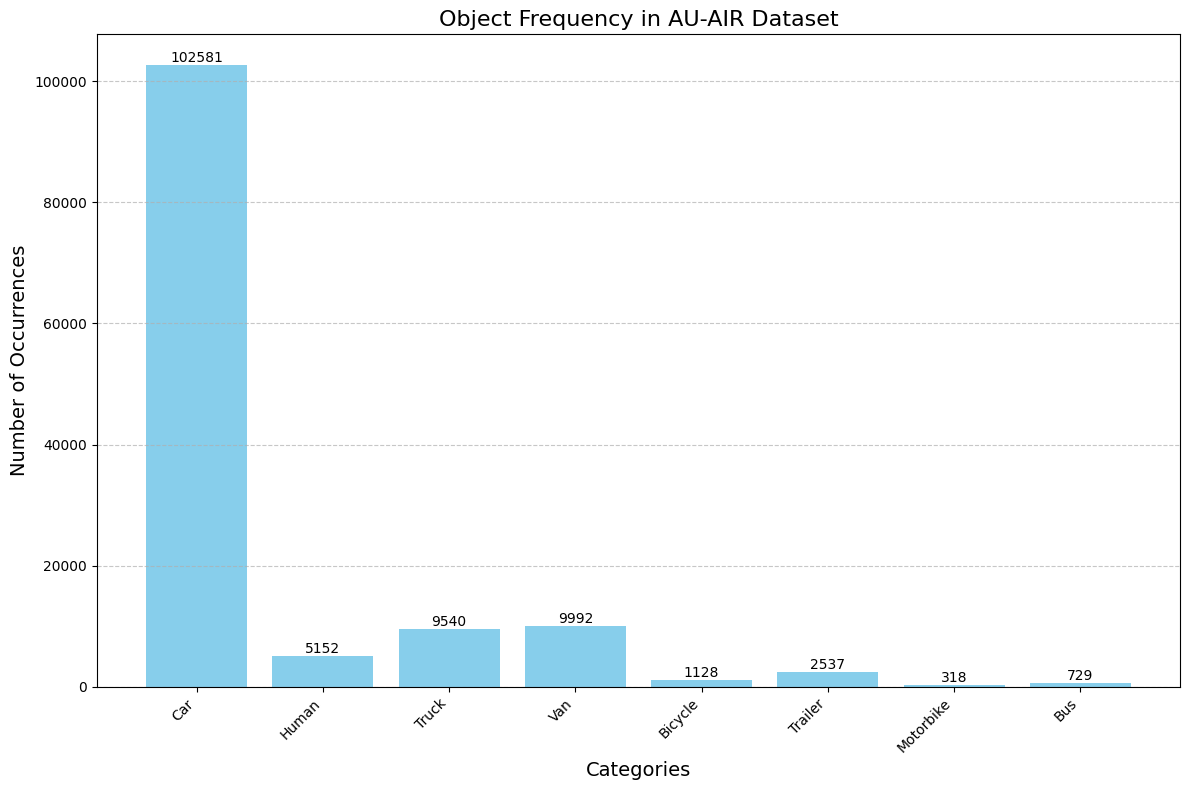

In [6]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# AU-AIR class mapping (adjust if different)
id2label = {
    0: "Human",
    1: "Car",
    2: "Truck",
    3: "Van",
    4: "Motorbike",
    5: "Bicycle",
    6: "Bus",
    7: "Trailer"
}
label2id = {v: k for k, v in id2label.items()}

# Load cleaned annotation file
with open("./annotations/auair_coco_cleaned.json", "r") as f:
    coco = json.load(f)

# Count class occurrences
class_counts = Counter()
for ann in coco["annotations"]:
    class_counts[ann["category_id"]] += 1

# Prepare for plotting
categories_ = [id2label[i] for i in class_counts.keys()]
values = list(class_counts.values())

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(categories_, values, color="skyblue")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Object Frequency in AU-AIR Dataset", fontsize=16)
ax.set_xticklabels(categories_, rotation=45, ha="right")

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
import random
import json

# Load full COCO data
with open("./annotations/auair_coco_cleaned.json", "r") as f:
    coco = json.load(f)

# Get all image IDs
all_images = coco["images"]
train_imgs, testval_imgs = train_test_split(all_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

# Utility to get annotations for given image list
def get_anns_for_imgs(images, all_anns):
    img_ids = set(img["id"] for img in images)
    return [ann for ann in all_anns if ann["image_id"] in img_ids]

# Create new COCO-style splits
def save_split(name, images, anns):
    data = {
        "images": images,
        "annotations": anns,
        "categories": coco["categories"]
    }
    with open(f"./annotations/auair_coco_{name}.json", "w") as f:
        json.dump(data, f, indent=4)
    print(f"✅ {name} split saved with {len(images)} images and {len(anns)} annotations.")

save_split("train", train_imgs, get_anns_for_imgs(train_imgs, coco["annotations"]))
save_split("val", val_imgs, get_anns_for_imgs(val_imgs, coco["annotations"]))
save_split("test", test_imgs, get_anns_for_imgs(test_imgs, coco["annotations"]))


✅ train split saved with 26258 images and 105274 annotations.
✅ val split saved with 3282 images and 13433 annotations.
✅ test split saved with 3283 images and 13270 annotations.


In [8]:
import os
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class AUAirCocoDataset(Dataset):
    def __init__(self, image_dir, annotation_path, processor, transform=None):
        """
        AU-AIR dataset in COCO format for object detection.

        Args:
            image_dir (str): Path to the folder containing image files.
            annotation_path (str): Path to the COCO-format JSON file.
            processor (transformers.Processor): Hugging Face processor (e.g., YolosImageProcessor).
            transform (albumentations.Compose, optional): Albumentations transforms for augmentation.
        """
        self.image_dir = image_dir
        self.annotation_path = annotation_path
        self.processor = processor
        self.transform = transform

        # Load COCO-style annotation JSON
        with open(self.annotation_path, "r") as f:
            self.coco = json.load(f)

        # Map image_id to image info
        self.image_id_to_info = {img["id"]: img for img in self.coco["images"]}

        # Map image_id to annotations
        self.image_id_to_annotations = {}
        for ann in self.coco["annotations"]:
            self.image_id_to_annotations.setdefault(ann["image_id"], []).append(ann)

        # List of image IDs
        self.image_ids = list(self.image_id_to_info.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Get image ID and corresponding info
        image_id = self.image_ids[idx]
        image_info = self.image_id_to_info[image_id]
        annotations = self.image_id_to_annotations.get(image_id, [])

        # Load image using PIL and convert to numpy array
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)

        # # Extract bboxes and category_ids
        # bboxes = [ann["bbox"] for ann in annotations]
        # category_ids = [ann["category_id"] for ann in annotations]

        # # Apply Albumentations transforms if provided
        # if self.transform:
        # # Check if 'Car' (id=1) is in category_ids to supress class imbalance
        #   # if 1 not in category_ids:
        #   transformed = self.transform(
        #       image=image_np,
        #       bboxes=bboxes,
        #       category_ids=category_ids
        #   )
        #   image_np = transformed["image"]
        #   bboxes = transformed["bboxes"]
        #   category_ids = transformed["category_ids"]

        #     # Reconstruct annotations after transformation
        #   annotations = [
        #         {
        #             "bbox": list(bbox),
        #             "category_id": cat_id,
        #             "area": bbox[2] * bbox[3]  # Calculate area (width * height)
        #         }
        #         for bbox, cat_id in zip(bboxes, category_ids)
        #     ]

        # Prepare target dictionary for the processor
        target = {
            "image_id": image_id,
            "annotations": annotations
        }

        # Use processor to encode image and annotations
        encoding = self.processor(images=image_np, annotations=target, return_tensors="pt")

        # Remove batch dimension to return a single example
        # encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding = {k: v.squeeze(0) if hasattr(v, "squeeze") else v for k, v in encoding.items()}

        return encoding


In [9]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# # Training transformations with data augmentation
# train_transform = A.Compose([
#     A.Resize(512, 512),  # Resize to a fixed size (YOLOS prefers fixed size)
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5),
#     A.MotionBlur(p=0.2),
#     A.HueSaturationValue(p=0.3),
#     ToTensorV2(),
#     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
# ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

# # Validation transformations (no augmentation)
# val_transform = A.Compose([
#     A.Resize(512, 512),
#     ToTensorV2(),
#     A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
# ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))


In [10]:
from transformers import TrainingArguments
from transformers import Trainer
import torch
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]
    # print("labels1: ",labels)
    labels = [l[0] if isinstance(l, list) else l for l in labels]
    # print("labels2: ",labels)
    # labels = [item["labels"] for item in batch]
    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": labels
    }
# def collate_fn(batch):
#     pixel_values = torch.stack([item["pixel_values"] for item in batch])
#     labels = [item["labels"] for item in batch]  # Leave this as is: list of dicts
#     return {
#         "pixel_values": pixel_values,
#         "labels": labels
#     }


In [11]:
from transformers import YolosImageProcessor
from transformers import YolosForObjectDetection
from transformers import YolosForObjectDetection

num_classes = 8

model = YolosForObjectDetection.from_pretrained(
    "hustvl/yolos-small",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # Allows resizing of classification head
)

# Define processor
processor = YolosImageProcessor.from_pretrained("hustvl/yolos-small")
processor.size = {"height": 512, "width": 512}  # ✅ override default resize


# Define dataset paths
image_dir = "./AU-AIR/images"
train_ann_path = "./annotations/auair_coco_train.json"
val_ann_path = "./annotations/auair_coco_val.json"
test_ann_path = "./annotations/auair_coco_test.json"

# Create datasets
train_dataset = AUAirCocoDataset(
    image_dir=image_dir,
    annotation_path=train_ann_path,
    processor=processor,
    # transform=train_transform
)

val_dataset = AUAirCocoDataset(
    image_dir=image_dir,
    annotation_path=val_ann_path,
    processor=processor,
    # transform=val_transform
)

test_dataset = AUAirCocoDataset(
    image_dir=image_dir,
    annotation_path=test_ann_path,
    processor=processor,
    # transform=val_transform
)
print(processor)

from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([9, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


YolosImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "YolosImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}



In [12]:
import wandb
wandb.login(key="1640c7993fb7d40efc5ce820586098b3f8a569f4")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Ali\_netrc
wandb: Currently logged in as: aliyigitbasaran (aliyigitbasaran-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [22]:
from tqdm import tqdm
import wandb

def eval_and_generate_yolos_predictions(model, dataloader, processor, device, with_loss=False, global_step=None):
    model.eval()
    results = []
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"): #data_loader:
            pixel_values = batch["pixel_values"].to(device)
            image_ids = [l["image_id"].item() for l in batch["labels"]]
            target_sizes = [l["orig_size"].to(device) for l in batch["labels"]]

            if with_loss:
                labels = [{k: v.to(device) for k, v in label.items()} for label in batch["labels"]]
                outputs = model(pixel_values=pixel_values, labels=labels)
                total_loss += outputs.loss.item()
                count += 1
            else:
                outputs = model(pixel_values=pixel_values)

            results_per_image = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)

            for i, prediction in enumerate(results_per_image):
                boxes = prediction["boxes"].cpu().numpy()
                scores = prediction["scores"].cpu().numpy()
                labels = prediction["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = box
                    results.append({
                        "image_id": image_ids[i],
                        "category_id": int(label),
                        "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                        "score": float(score)
                    })

    if with_loss:
        avg_val_loss = total_loss / max(count, 1)
        wandb.log({"val/loss": avg_val_loss}, step=global_step)
        return results
    else:
        return results


In [ ]:
import os
import json
import wandb
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_map_coco(predictions, gt_annotation_path, step_label="val"):
    os.makedirs("predictions", exist_ok=True)
    pred_path = f"./predictions/{step_label}_predictions.json"

    with open(pred_path, "w") as f:
        json.dump(predictions, f)

    coco_gt = COCO(gt_annotation_path)
    coco_dt = coco_gt.loadRes(pred_path)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # === Class-wise AP logging ===
    class_wise_ap = []
    precisions = coco_eval.eval['precision']  # [T, R, K, A, M]
    cat_ids = coco_gt.getCatIds()
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_gt.loadCats(cat_ids)}

    for idx, cat_id in enumerate(cat_ids):
        precision = precisions[0, :, idx, 0, 0]  # IoU=0.5, area=all, maxDets=100
        precision = precision[precision > -1]
        ap = float(precision.mean()) if precision.size > 0 else 0.0
        ap_percent = ap * 100  # 🔁 Convert to percentage
        class_name = cat_id_to_name.get(cat_id, f"cls_{cat_id}")
        class_wise_ap.append([class_name, ap_percent])
        wandb.log({f"{step_label}/AP/{class_name}": ap_percent})

    # === Log overall mAP values in percentage ===
    map_50_95 = coco_eval.stats[0] * 100
    map_50 = coco_eval.stats[1] * 100
    map_75 = coco_eval.stats[2] * 100

    wandb.log({
        f"{step_label}/mAP_50_95": map_50_95,
        f"{step_label}/mAP_50": map_50,
        f"{step_label}/mAP_75": map_75
    })

    # 🔁 Add mAPas a new row at the bottom
    class_wise_ap.append(["mAP", map_50])

    # ✅ Log AP table to W&B
    wandb.log({
        f"{step_label}/AP_table": wandb.Table(
            data=class_wise_ap,
            columns=["Class", "AP"]
        )
    })


In [ ]:
import torch
from tqdm import tqdm
from collections import defaultdict
import wandb

def custom_train(model, train_dataloader, val_dataloader, test_dataloader, processor, optimizer, lr_scheduler, device,
                 num_epochs=10, log_interval=100,
                 train_ann_path="", val_ann_path="", test_ann_path=""):

    model.to(device)
    global_step = 0
    wandb.watch(model, log="all")

    ema_loss = None  # EMA start
    alpha = 0.01     # EMA multiplier

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        print(f"Epoch {epoch + 1}/{num_epochs}")

        for step, batch in enumerate(tqdm(train_dataloader)): # tqdm
            pixel_values = batch["pixel_values"].to(device)
            # print("pixel_values: ", pixel_values)
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
            # labels = [{k: v.to(device) for k, v in label.items()} for label in batch['labels']]
            # print("labels: ", labels)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            global_step += 1

            # EMA Loss Update
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss = alpha * loss.item() + (1 - alpha) * ema_loss

            # === log loss & mAP every log_interval ===
            if global_step % log_interval == 0:
                avg_loss = running_loss / log_interval
                wandb.log({
                    "avg_per_log_interval_train/loss": avg_loss,
                    "ema_train/loss": ema_loss
                }, step=global_step)
                print(f"Step {global_step}: avg_loss = {avg_loss:.4f}, ema_loss = {ema_loss:.4f}")
                running_loss = 0.0

                # # === Train mAP via pycocotools (full dataloader) ===
                # val_at_train_preds = eval_and_generate_yolos_predictions(model, val_dataloader, processor, device, with_loss=True)
                # if(len(val_at_train_preds) != 0):
                #     print("Prediction Results: ")
                #     evaluate_map_coco(val_at_train_preds, val_ann_path, step_label="on_train")
                # else:
                #     print("No Prediction generated!!")

        # === VALIDATION ===
        model.eval()
        val_preds = eval_and_generate_yolos_predictions(model, val_dataloader, processor, device, with_loss=True)
        evaluate_map_coco(val_preds, val_ann_path, step_label="val")

    # === FINAL TEST EVALUATION ===
    print("\n🧪 Running final evaluation on test set...")
    test_preds = eval_and_generate_yolos_predictions(model, test_dataloader, processor, device)
    evaluate_map_coco(test_preds, test_ann_path, step_label="test")


In [ ]:
from transformers import get_scheduler
from tqdm import tqdm
import wandb
num_classes = 8
categories = train_dataset.coco["categories"]
id2label = {cat["id"]: cat["name"] for cat in categories}
label2id = {cat["name"]: cat["id"] for cat in categories}
model = YolosForObjectDetection.from_pretrained(
    "hustvl/yolos-small",
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Allows resizing of classification head
)
wandb.init(project="DI725_Assg2_YOLOS_Finetune", name="yolos-small-auair-finetune", reinit=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

lr_scheduler = get_scheduler(
    name="constant_with_warmup", #linear
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * 10
)


custom_train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    test_dataloader=test_loader,
    processor=processor,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    num_epochs=20,
    log_interval=200, # 100
    train_ann_path="./annotations/auair_coco_train.json",
    val_ann_path="./annotations/auair_coco_val.json",
    test_ann_path="./annotations/auair_coco_test.json"
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([9, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


  2%|▏         | 57/3283 [00:42<40:08,  1.34it/s]

In [ ]:
from transformers import TrainerCallback
import wandb
import numpy as np
from collections import defaultdict

class WandBLogEveryNSteps(TrainerCallback):
    def __init__(self, log_every_n_steps=100):
        self.log_every_n_steps = log_every_n_steps
        self.losses = []

    def on_step_end(self, args, state, control, **kwargs):
        logs = kwargs.get("logs", {})
        if "loss" in logs:
            self.losses.append(logs["loss"])
        if state.global_step % self.log_every_n_steps == 0 and len(self.losses) >= self.log_every_n_steps:
            avg_loss = sum(self.losses[-self.log_every_n_steps:]) / self.log_every_n_steps
            wandb.log({"rolling_train_loss": avg_loss}, step=state.global_step)


# AU-AIR class labels
id2label = {
    0: "Human",
    1: "Car",
    2: "Truck",
    3: "Van",
    4: "Motorbike",
    5: "Bicycle",
    6: "Bus",
    7: "Trailer"
}

def compute_metrics(p):
    pred_logits = p.predictions[0]
    ap_dict = defaultdict(float)
    total = 0

    for preds in pred_logits:
        class_ids = np.argmax(preds, axis=-1)
        for class_id in class_ids:
            ap_dict[int(class_id)] += 1
            total += 1

    metrics = {}
    table_data = []
    for class_id, count in ap_dict.items():
        class_name = id2label.get(class_id, f"cls_{class_id}")
        ap = count / total
        metrics[f"AP/{class_name}"] = ap
        table_data.append([class_name, ap])

    metrics["mAP"] = np.mean(list(ap_dict.values())) / total if total > 0 else 0.0

    # ✅ Log WandB table manually (class, AP)
    wandb.log({
        "AP_table": wandb.Table(data=table_data, columns=["Class", "AP"])
    })

    return metrics




In [62]:


training_args = TrainingArguments(
    output_dir="./yolos-finetuned",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    num_train_epochs=10,
    eval_strategy="epoch",             # Evaluate at the end of each epoch
    save_strategy="epoch",                   # Save model at the end of each epoch
    logging_steps=50,                        # Just console logging
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    report_to="wandb",                       # Enable wandb logging
    run_name="yolos-small-auair-finetune",   # WandB run name
    save_total_limit=2,                      # Only keep last 2 checkpoints
    load_best_model_at_end=True,             # Based on eval loss
    remove_unused_columns=False,             # Required for object detection inputs
    disable_tqdm=False                       # Keep tqdm progress bar active
)


trainer = Trainer(
    model=model,  # YOLOS-small model loaded earlier
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,  # Required by Trainer API
    compute_metrics=compute_metrics,
    callbacks=[WandBLogEveryNSteps(log_every_n_steps=100)],
    data_collator=collate_fn
)


NameError: name 'compute_metrics' is not defined

In [ ]:
# import torch
# from tqdm import tqdm
# from collections import defaultdict
# import wandb

# def custom_train(model, train_dataloader, val_dataloader, test_dataloader, processor, optimizer, lr_scheduler, device, num_epochs=10, log_interval=100):
#     model.to(device)
#     global_step = 0
#     wandb.watch(model, log="all")

#     # Initialize running class prediction stats for train AP table
#     train_ap_dict = defaultdict(int)
#     train_total = 0

#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         print(f"Epoch {epoch + 1}/{num_epochs}")

#         for step, batch in enumerate(tqdm(train_dataloader)):
#             pixel_values = batch["pixel_values"].to(device)
#             labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

#             outputs = model(pixel_values=pixel_values, labels=labels)
#             loss = outputs.loss

#             loss.backward()
#             optimizer.step()
#             lr_scheduler.step()
#             optimizer.zero_grad()

#             running_loss += loss.item()
#             global_step += 1

#             # Update class count statistics based on predicted logits
#             with torch.no_grad():
#                 class_ids = outputs.logits.argmax(dim=-1)
#                 for pred in class_ids:
#                     for cid in pred.cpu().numpy():
#                         train_ap_dict[int(cid)] += 1
#                         train_total += 1

#             # Log training loss and AP table every N steps
#             if global_step % log_interval == 0:
#                 avg_loss = running_loss / log_interval
#                 wandb.log({"train/loss": avg_loss}, step=global_step)
#                 print(f"Step {global_step}: loss = {avg_loss:.4f}")
#                 running_loss = 0.0

#                 # Create and log train AP table
#                 train_ap_table = []
#                 for cid, count in train_ap_dict.items():
#                     class_name = id2label.get(cid, f"cls_{cid}")
#                     ap = count / train_total if train_total > 0 else 0
#                     train_ap_table.append([class_name, ap])
#                     wandb.log({f"Train_AP/{class_name}": ap}, step=global_step)

#                 wandb.log({
#                     "train/AP_table": wandb.Table(data=train_ap_table, columns=["Class", "AP"])
#                 }, step=global_step)

#         # === VALIDATION ===
#         model.eval()
#         all_preds = []
#         with torch.no_grad():
#             for batch in val_dataloader:
#                 pixel_values = batch["pixel_values"].to(device)
#                 labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
#                 outputs = model(pixel_values=pixel_values, labels=labels)
#                 all_preds.append(outputs.logits)

#         predictions = torch.cat(all_preds, dim=0).cpu().numpy()
#         ap_table = []
#         ap_dict = defaultdict(int)
#         total = 0

#         for preds in predictions:
#             class_ids = preds.argmax(axis=-1)
#             for cid in class_ids:
#                 ap_dict[int(cid)] += 1
#                 total += 1

#         for cid, count in ap_dict.items():
#             class_name = id2label.get(cid, f"cls_{cid}")
#             ap = count / total
#             ap_table.append([class_name, ap])
#             wandb.log({f"AP/{class_name}": ap}, step=global_step)

#         mAP = sum([row[1] for row in ap_table]) / len(ap_table) if ap_table else 0.0
#         wandb.log({"val/mAP": mAP, "val/AP_table": wandb.Table(data=ap_table, columns=["Class", "AP"])},
#                   step=global_step)
#         print(f"Epoch {epoch + 1} validation mAP: {mAP:.4f}")

#     # === FINAL TEST EVALUATION ===
#     print("\n🧪 Running final evaluation on test set...")
#     model.eval()
#     test_preds = []
#     with torch.no_grad():
#         for batch in test_dataloader:
#             pixel_values = batch["pixel_values"].to(device)
#             labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
#             outputs = model(pixel_values=pixel_values, labels=labels)
#             test_preds.append(outputs.logits)

#     test_predictions = torch.cat(test_preds, dim=0).cpu().numpy()
#     test_ap_table = []
#     test_ap_dict = defaultdict(int)
#     test_total = 0

#     for preds in test_predictions:
#         class_ids = preds.argmax(axis=-1)
#         for cid in class_ids:
#             test_ap_dict[int(cid)] += 1
#             test_total += 1

#     for cid, count in test_ap_dict.items():
#         class_name = id2label.get(cid, f"cls_{cid}")
#         ap = count / test_total
#         test_ap_table.append([class_name, ap])
#         wandb.log({f"Test_AP/{class_name}": ap}, step=global_step)

#     test_mAP = sum([row[1] for row in test_ap_table]) / len(test_ap_table) if test_ap_table else 0.0
#     wandb.log({"test/mAP": test_mAP, "test/AP_table": wandb.Table(data=test_ap_table, columns=["Class", "AP"])},
#               step=global_step)
#     print(f"✅ Final test mAP: {test_mAP:.4f}")


In [110]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 